# Week 2 - Sampling & Reliability

Up until this week, we have assumed that the corpus you have used for analysis assignments represented a *meaningful* assemblage of texts from which reasonable inferences could be drawn about the social game, social world and social actors that produced it. 

This week, we ask you to build a corpus for preliminary analysis and articulate what your sample represents in context of your final project. We begin by exploring how we can get *human* readings of content at scale. We want to gather and utilize human responses for several reasons. First, we may want to use crowdsourced human scores as the primary method of coding, extracting or organizing content (as it was in two of the assigned readings). Second, we may want to validate or tune a computational algorithm we may have developed in terms of how it is associated with human meanings or experience. Finally, we may want to use human coding on a sample of data as the basis for training a model or algorithm to then extrapolate *human-like* annotations to the entire population. Here intelligent sampling is critical to maximize effective maching training. 

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## <span style="color:red">*Pitch the Domain of your Project*</span>

<span style="color:red">In the two cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words) and **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words)? [**Note**: your individual or collective project can change over the course of the quarter if new data and/or analysis opportunities arise or if old ones fade away.]

## ***What?*** 
For my final project, I am planning to analyze GoFundMe campaigns to learn about the types of issues people actually donate to and the kinds of campaign content that motivate donations. GoFundMe is a crowdfunding platform that allows people to fund raise for various life situations. Billions of dollars have been raised on this site and millions of people have donated on this site. The social actors involved here are the donors and the recipients of the donations and they interact on this site through the content and updates posted by the recipient as well as the act of donation by the donors and comments by the donors.

## ***Why?***
More and more fundraisers are going online and fundraisers are becoming of varied nature - from personal to charitable organizations. At the same time, there are many social issues and needs all around the world. Some of them more personal and heart-wrenching, and others more structural and long-standing. This project can help shed light on some of the common attributes of highly donated campaigns compared to those less successful. This would help us to understand the issues or needs important to us and the characteristics of donations that allow us to trust the campaign's effectiveness in alleviating the issues and donate to their cause. This can help us create more effective campaign content but also help us identify issues that might not do so well based on what we perceive to be more likely to attract donations.

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

My current sample design is a stratified sampling method where I will randomly select 10 campaigns from each of the 18 categories of fundraisers in GoFundMe. However as I am not able to see all the campaigns for each category, I will be randomly select the 10 campaigns from the first 100 shown on the page for each category. 

I am looking at the social game of campaign content and donations. This sampling method is would allow a diverse range of campaigns to be analyzed. However, since some categories are likely to be more popular than others, this may mean that the probability of a post being chosen from a less popular category will be higher than another that is tagged in the more popular one. Also, since I am choosing from the top of the campaigns not all of them, it is also possible that my campaigns could be all successful and lack unsuccessful samples. Alternatively, I could stratify based on successfulness of the campaign including a mix of successful and unsuccessful samples.

Scaling up this sample would first be to finish looking at all the campaigns of GoFundMe, or even to look at other websites for comparison.

# Example Annotation Dataset

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

In [2]:
%%html
<img source="loopdesign.png">

[Click here for loop design](loopdesign.png)

In [3]:
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [4]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [5]:
anno.annotations.shape

(800, 8)

In [166]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [167]:
anno.missing_values

[-1]

In [6]:
for a in anno.annotations[0:10]:
    print(a)

[ 1  2  3 -1 -1 -1 -1 -1]
[ 0  0  0 -1 -1 -1 -1 -1]
[ 2  2  1 -1 -1 -1 -1 -1]
[ 3  3  3 -1 -1 -1 -1 -1]
[ 2  2  2 -1 -1 -1 -1 -1]
[ 1  1  1 -1 -1 -1 -1 -1]
[ 3  2  2 -1 -1 -1 -1 -1]
[ 1  1  1 -1 -1 -1 -1 -1]
[ 1  1  2 -1 -1 -1 -1 -1]
[ 2  3  2 -1 -1 -1 -1 -1]


In [7]:
anno.annotations[:,0][:10]

array([1, 0, 2, 3, 2, 1, 3, 1, 1, 2])

In [8]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [9]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [10]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

In [11]:
len(anno.annotations[:,0])

800

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


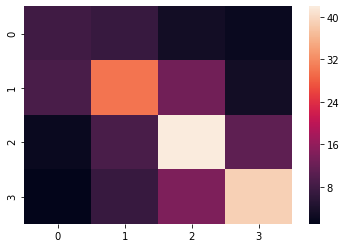

In [12]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [13]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [14]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [15]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [16]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [17]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


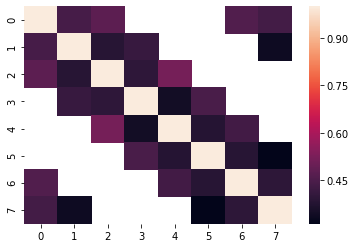

In [18]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [19]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [20]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [21]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

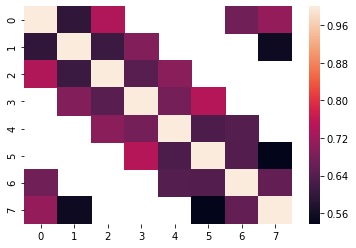

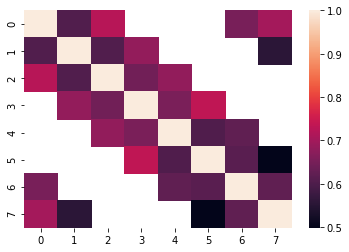

In [22]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [23]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <span style="color:red">*Your turn*</span>

<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides in the Assignment link on Canvas, or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [24]:
df = pandas.read_csv("mturk/annotated.csv")
print(len(df.groupby('workerid').size())) 
# 25 workers

25


In [25]:
categories = {'No Donation': 1,
              'Donate $5' : 2,
              'Donate $10': 3,
              'Donate $50': 4,
              'Donate $100 or more': 5}

df.replace(categories, inplace=True)

In [26]:
def create_array(df, workerid_col, q_col, label_col):
    unique_q = df[q_col].unique()
    unique_workers = df[workerid_col].unique()
    n = len(unique_workers)
    array = []
    
    for w_id in unique_workers:
        init = [-1]*len(unique_q)
        data = df[df[workerid_col]==w_id]
        for q in data[q_col]:
            init[q-1] = data[data[q_col]==q].reset_index()[label_col][0]
        array.append(init)
        
    return array

In [33]:
array_eachquestion = np.array(list(df['label'])).reshape(12,5)
array_eachquestion
# 12 questions each answered by 5 unique workers

array([[3, 2, 1, 2, 3],
       [1, 2, 2, 2, 2],
       [1, 3, 2, 2, 1],
       [3, 3, 2, 5, 3],
       [2, 3, 2, 1, 2],
       [3, 2, 3, 3, 2],
       [2, 1, 1, 2, 5],
       [1, 2, 1, 2, 3],
       [2, 1, 2, 3, 2],
       [3, 3, 4, 2, 3],
       [2, 2, 1, 1, 1],
       [2, 2, 3, 3, 4]])

In [34]:
array = create_array(df, 'workerid', 'textnum', 'label')
array = np.array(array).transpose()
array.shape

(12, 25)

In [35]:
array

array([[ 3,  2,  1,  2,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1,  2,  1,  2,  2,  2, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1,  2, -1, -1,  3, -1,  1,  2,  1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1,  3, -1,  3, -1, -1,  2, -1, -1, -1, -1,  3,  5, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1,  2, -1, -1,  3,  2, -1, -1, -1, -1, -1,  2,  1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1,  1, -1, -1, -1,  2, -1,  5, -1, -1, -1, -1, -1,
         2, -1, -1,  1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1,  1, -1, -1,  3, -1,  2, -1, -1, -1, -1,  1, -1,
        -1, -1, -1, -1,  2, -1, -1, -1, -1],
       [-1, -1, -1, -1,  2, -1, -1,  3, -1, -1, -1, -1, -1, -1,  2, -1,
         2, -1, -1, -1, -1,  1, -1, -1, -1],
       [-1, -1, -1, -1,  3, -1,  3, -1, -1, -1, -1, -1, -1, -1, 

In [36]:
anno1 = AnnotationsContainer.from_array(array, missing_values=[-1])
#12 questions answered by 25 workers

In [37]:
pyanno.measures.agreement.labels_frequency(anno1.annotations,5)

array([0.21666667, 0.43333333, 0.28333333, 0.03333333, 0.03333333])

In [38]:
anno1.annotations[:,0] #First coder

array([ 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1])

In [39]:
anno1.annotations[:,1] #Second coder

array([ 1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1])

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


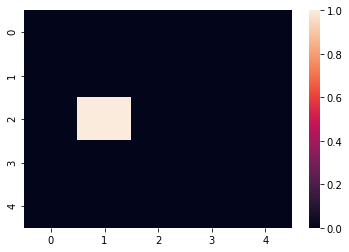

In [40]:
c = pyanno.measures.agreement.confusion_matrix(anno1.annotations[:,0], anno1.annotations[:,1],5)
print(c)
ac = seaborn.heatmap(c)
plt.show()

In [41]:
n = pairwise_matrix(scotts_pi, anno1.annotations)

/usr/local/lib/python3.7/site-packages/pyanno/measures/helpers.py:166: RuntimeWarning: invalid value encountered in double_scalars
  return (observed_agreement - chance_agreement) / (1. - chance_agreement)


In [42]:
m = pairwise_matrix(cohens_kappa, anno1.annotations)

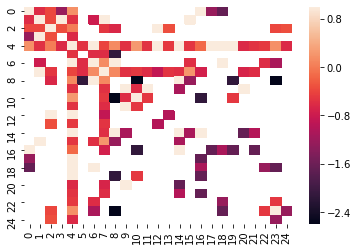

In [43]:
an = seaborn.heatmap(n)
plt.show()

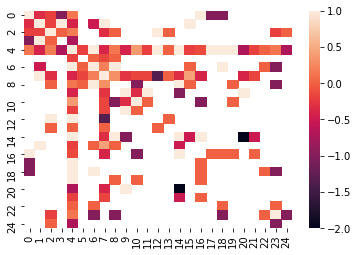

In [44]:
am = seaborn.heatmap(m)
plt.show()

In [45]:
print(pairwise_metric_average(scotts_pi,anno1.annotations), pairwise_metric_average(cohens_kappa,anno1.annotations))
#0-1 scott and krippendorff
#-1-1 cohen and fleiss (more than chance or less than chance)

-0.42899923901952575 -0.04459623434721265


In [46]:
krippendorffs_alpha(anno1.annotations[::])

0.16087231352718068

In [47]:
fleiss_kappa(anno1.annotations[::])

-0.025223759153783606

/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


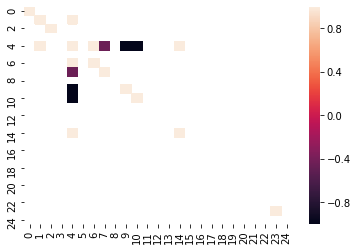

In [48]:
#n = pairwise_matrix(pearsons_rho, anno1.annotations)
#an = seaborn.heatmap(n)
#plt.show()
m = pairwise_matrix(spearmans_rho, anno1.annotations)
am = seaborn.heatmap(m)
plt.show()

In [49]:
print(pairwise_metric_average(spearmans_rho,anno1.annotations))

0.09213106741667369


### Comments on intercoder reliability

Intercoder reliability is low at 0.16 for Krippendorff's flexible $\alpha$ and 0.09 for Spearman's $\rho$. These metrics are more appropriate metrics in this case since the options are ordinal, where the coder could choose whether to donate 0 or 5, 10, 50 or 100 or more. The low intercoder reliability is not surprising since this coding exercise asks for their opinions on whether they will donate the specified amounts given the text and the response can be very subjective. Another reason for the low reliability is that the 12 questions with 5 responses each were also answered by 25 workers meaning that each worker only answered a few questions each, hence they are less likely to be consistent.

# Models

However, what if some coders are better than others. The prior measures all rely on the assumption that all coders are equally good. What if some are worse than others? Now we use Rzhetsky et al (2009) and Dawid & Skene's models to make inference about true label classes by downweighting bad or deviant coders. Pyanno provides three relevant models: ModelA, ModelB, and ModelBt. Model A can only be currently run on a balanced 8-coder design, but assesses accuracy purely based on agreement. Model B with $\theta$s models the relationship between each coder and code. Model B is the Dawid & Skene model from the reading. The following image schematically suggests the relationship between the models. <img src="../data/models.png">

The models should provide similar results. To estimate the parameters for any models, we first need to create a new model. 

In [50]:
# create a new instance of model A, with 4 label classes
model = ModelA.create_initial_state(4)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.63956223 0.75065694 0.84884079 0.82737025 0.80220163 0.94193733
 0.86150573 0.93588338]
-3706.3608569047124


In [51]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
samples

array([[0.81184761, 0.70571327, 0.76562546, ..., 0.76500306, 0.77403073,
        0.6200575 ],
       [0.84207408, 0.7223234 , 0.77057019, ..., 0.76541638, 0.76981749,
        0.67039844],
       [0.84207408, 0.7223234 , 0.77057019, ..., 0.76541638, 0.76981749,
        0.67039844],
       ...,
       [0.72645261, 0.79767404, 0.77198157, ..., 0.78845247, 0.74686541,
        0.78373827],
       [0.74787809, 0.74985833, 0.78505246, ..., 0.79022579, 0.76030756,
        0.76107494],
       [0.74787809, 0.74985833, 0.78505246, ..., 0.79022579, 0.76030756,
        0.76107494]])

Pyanno allows one to use either MLE (maximum likelihood estimation) or MAP (maximum a posteriori estimation) to estimate model parameters. Note that the parameters here correspond to our estimation of the accuracy of each annotator.

In [52]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.79546635 0.73335101 0.76957323 0.71027616 0.72287461 0.71945277
 0.75770115 0.7124429 ]
-2817.519736351871


In [53]:
model = ModelB.create_initial_state(4, 8)
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[7.73398728e-01 2.01020245e-01 2.55810269e-02 1.20101219e-26]
  [1.47832659e-01 7.11503767e-01 7.66499157e-02 6.40136580e-02]
  [1.97431020e-02 1.48708709e-01 6.96639326e-01 1.34908863e-01]
  [2.52463780e-18 2.13647377e-02 8.51550428e-02 8.93480220e-01]]

 [[7.19395465e-01 2.01828761e-01 7.87757734e-02 1.55486964e-13]
  [1.33941799e-01 7.07223261e-01 1.10418200e-01 4.84167403e-02]
  [2.72093282e-02 1.65178369e-01 6.71232700e-01 1.36379603e-01]
  [2.15358721e-30 5.38211823e-02 1.21871740e-01 8.24307077e-01]]

 [[8.50073137e-01 1.22955501e-01 2.69713621e-02 3.64395738e-42]
  [8.93514251e-02 7.89280333e-01 8.93429608e-02 3.20252811e-02]
  [6.11638366e-02 1.29121422e-01 7.03992731e-01 1.05722011e-01]
  [6.53666390e-03 5.12606512e-02 2.10869595e-01 7.31333090e-01]]

 [[6.99612801e-01 2.70976969e-01 2.94102301e-02 8.57899704e-52]
  [9.67171336e-02 7.62615701e-01 1.09523823e-01 3.11433425e-02]
  [1.81150586e-02 1.45472330e-01 6.85587954e-01 1.50824657e-01]
  [2.71897111e-47 2.98511124e-02 2

Once we have model parameters estimated, we can now make inferences about the true label classes. We can calculate the posterior distribution over the true label classes.

In [54]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[1.20741380e-42 1.00240780e-01 7.90821679e-01 1.08937540e-01]
 [9.92682453e-01 7.07056554e-03 2.46981317e-04 2.03944498e-49]
 [1.07420297e-03 5.51435353e-02 9.37476514e-01 6.30574822e-03]
 ...
 [8.15378491e-04 3.51193436e-02 9.59859130e-01 4.20614824e-03]
 [1.34481992e-44 2.14447325e-03 9.16166870e-01 8.16886569e-02]
 [2.14745550e-01 7.69057353e-01 1.61970966e-02 2.01807019e-26]]


Let's turn the posterior of the first 100 samples into a heatmap.

In [55]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [56]:
votes = []
for r in anno.annotations:
    v = [0] * len(anno.labels)
    votes.append(v)
    for a in r:
        if a > -1:
            v[a] += 1
votes_array = np.array(votes)
votes_array

array([[0, 1, 1, 1],
       [3, 0, 0, 0],
       [0, 1, 2, 0],
       ...,
       [0, 1, 2, 0],
       [0, 0, 2, 1],
       [1, 2, 0, 0]])

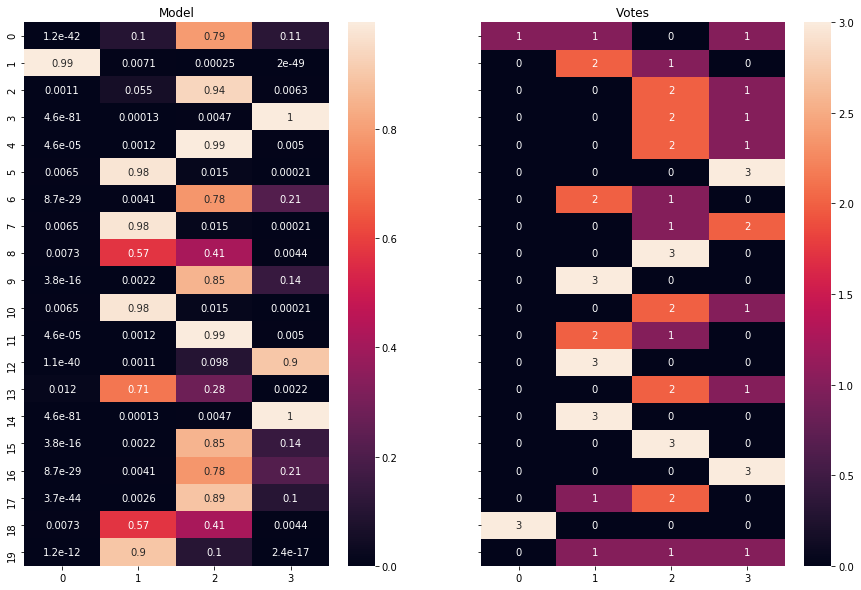

In [57]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)
num_questions = 20

seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
seaborn.heatmap(posterior[:num_questions], annot=True, ax =ax1)
ax1.set_title("Model")
ax2.set_title("Votes")
plt.show()

This differs markedly from taking annotator scores at face value (Add comparison of average values)

In [58]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [59]:
print(samples[0].mean(axis=0))
print(samples[0].std(axis=0))

[[[0.72221501 0.21013272 0.04709763 0.02055464]
  [0.14750649 0.68879713 0.0965667  0.06712968]
  [0.03005649 0.15448611 0.68060529 0.13485212]
  [0.01299653 0.03115414 0.10607621 0.84977312]]

 [[0.67006577 0.21370774 0.08802416 0.02820234]
  [0.13436732 0.68820371 0.12391605 0.05351292]
  [0.03258501 0.17188317 0.66173056 0.13380126]
  [0.00993496 0.06799928 0.13219901 0.78986675]]

 [[0.7896647  0.14306558 0.04821144 0.01905828]
  [0.1011465  0.75205333 0.10441261 0.04238756]
  [0.06614984 0.13867287 0.6828757  0.11230159]
  [0.01428619 0.06075777 0.22701353 0.69794251]]

 [[0.65162637 0.27879317 0.04900835 0.02057211]
  [0.10529323 0.73527358 0.12020957 0.03922362]
  [0.02566805 0.15331604 0.66694265 0.15407325]
  [0.00951607 0.03886264 0.23282306 0.71879824]]

 [[0.76330835 0.13636987 0.08103132 0.01929046]
  [0.1245065  0.68049686 0.14649431 0.04850232]
  [0.02101024 0.21260965 0.63593906 0.13044105]
  [0.00845539 0.06795787 0.19201767 0.73156907]]

 [[0.72282787 0.21825918 0.041

Let's try everything again with ModelBt

In [60]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 8)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.6051611  0.80379948 0.78631241 0.88283132 0.84359786 0.68132796
 0.76292997 0.9175222 ]
-2960.09249251903


In [61]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.79130403 0.74070206 0.76221912 0.72523854 0.71641118 0.71858591
 0.77322426 0.7166892 ]
-2811.946211451944


In [62]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[0.01110254 0.28932993 0.36495364 0.33461389]
 [0.99021785 0.00241997 0.00405172 0.00331045]
 [0.00249953 0.05506856 0.93459839 0.00783351]
 ...
 [0.0025289  0.04396839 0.94557718 0.00792553]
 [0.00249387 0.00571338 0.93247846 0.05931429]
 [0.0319025  0.93879857 0.01612446 0.01317447]]


Let's visualize the posterior of the first 10 samples according to ModelBt.

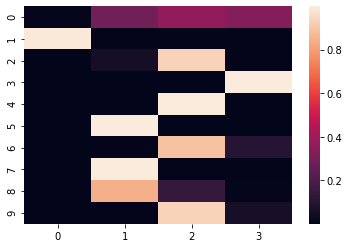

In [63]:
ax = seaborn.heatmap(posterior[:10,])
plt.show()

The property of these scores is that they enable us to identify the most likely code assuming coders of unequal quality, which also allows us to break ties when we know coder identity. For some analyses, we may simply use the posterior themselves rather than the most probably code outcome.

# Generating Annotations

Pyanno also allows one to generate artificial data from a model.

In [64]:
model = ModelBt.create_initial_state(4, 3, theta=[0.99,0.75,0.25])
#randome generate annotations with 4 label classes and 3 annotators. The accuracy of the three annotators are 0.99, 0.75, and 0.25 respectively.
model.generate_annotations(20)

array([[2, 2, 0],
       [0, 0, 0],
       [1, 1, 2],
       [0, 0, 1],
       [1, 1, 1],
       [1, 1, 0],
       [1, 1, 0],
       [0, 0, 0],
       [1, 1, 3],
       [2, 2, 1],
       [1, 1, 0],
       [1, 1, 1],
       [0, 0, 0],
       [2, 2, 0],
       [1, 3, 2],
       [0, 0, 3],
       [0, 0, 2],
       [0, 0, 0],
       [1, 1, 1],
       [0, 0, 3]])

## Visualizing coder accuracy

Pyanno provides a [graphical user interface](http://docs.enthought.com/uchicago-pyanno/user_guide.html) for making plots. However, it is not compatible with ipython notebooks. Nevertheless, nothing prevents us from making plots using matplotlib. Let's make a plot of the accuracy of each annotator inferred from ModelA.

In [65]:
model = ModelBt.create_initial_state(4, 8)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)#.mean(axis = 1).mean(axis = 1)
y_ci = samples.std(axis=0)#.mean(axis = 1).mean(axis = 1)

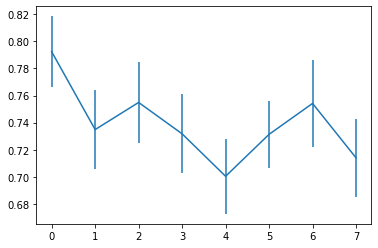

In [66]:
plt.figure()
plt.errorbar(range(8),y, yerr = y_ci)
plt.show()

# Example with articles that use the General Social Survey

I performed a recent study in which the variables from thousands of articles were associated with those used in the General Social Survey, a widely used population sample, in order to interrogate how social science analyses are performed. Each article was reread and coded by a balanced set of three student coders using a 6 choose 3 design, such that all possible 3-coder-subsets (20) coded an equal number of articles. Coding was performed through a website that allowed students access to the digital article. To evaluate the validity of the student codes, we also recruited a sample of authors associated with 97 of our published articles to fill out the same online survey. 

Because not all coders coded items with equal accuracy, and because “don’t know” was an optional answer, leading to potential ties, we used a generative, probabilistic model to estimate the maximum a posteriori probability (MAP) prediction that an item’s code is true, which integrates over the estimated accuracy of coders, assuming only that the entire population of coders is slightly more often right than wrong. The model (“Model B”) is based on a simple underlying generation process that directly accounts for the probability that coded values are correct (Rzhetsky et al. 2009). For each coded value j, a set of parameters, denoted γj, represents the probability that each coded value is correct. For the ith coder (i = 1, 2, …, 6), we introduce a matrix of probabilities, denoted λ(i)x|y, that defines the probability that she assigns code x (e.g., Dependent variable) to a GSS variable with correct annotation y. For a perfect coder, the matrix λ(i)x|y would equal the identity matrix and her vote would count most toward the total. For a coder that always codes incorrectly—a “troll”—her matrix λ(i)x|y will have all its value off the diagonal and will only minimally influence the posterior. We co-authored the open source pyanno software that implements this model.

Getting the data for each content analysis survey regarding how GSS variables were used in a large population of social science articles.

In [67]:
#anno_vdep = AnnotationsContainer.from_file(missing_values=[-1], filename="GSSvariable_testSdependent.csv")
dev = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testSdependent.csv", dtype=int, delimiter=",")
anno_dv = AnnotationsContainer.from_array(dev)

ind = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testSindependent.csv", dtype=int, delimiter=",")
anno_iv = AnnotationsContainer.from_array(ind)

cent = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testScentral.csv", dtype=int, delimiter=",")
anno_cv = AnnotationsContainer.from_array(cent)

cont = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testScontrol.csv", dtype=int, delimiter=",")
anno_ctv = AnnotationsContainer.from_array(cont)

test = np.loadtxt(fname="../data/dataforgssstudy/testH.csv", dtype=int, delimiter=",")
anno_test = AnnotationsContainer.from_array(test)

Let's examine the data structure.

In [68]:
dev.shape

(21461, 6)

In [69]:
anno_dv.labels

[0, 1]

In [70]:
anno_dv.missing_values

[-1]

In [71]:
anno_dv.annotations.shape

(21461, 6)

First, let's use Cohen's $\kappa$ to measure agreement between coders...

In [72]:
m = pairwise_matrix(cohens_kappa, anno_dv.annotations)
print(m)

[[1.         0.62426874 0.46682841 0.44599604 0.16569888 0.36657805]
 [0.62426874 1.         0.53480937 0.52673854 0.3306905  0.59513211]
 [0.46682841 0.53480937 1.         0.50580068 0.42393752 0.49833997]
 [0.44599604 0.52673854 0.50580068 1.         0.46517493 0.47023754]
 [0.16569888 0.3306905  0.42393752 0.46517493 1.         0.66190749]
 [0.36657805 0.59513211 0.49833997 0.47023754 0.66190749 1.        ]]


Let's visualize that...

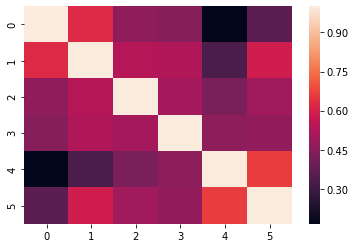

In [73]:
ax = seaborn.heatmap(m)
plt.show()

In [74]:
pairwise_metric_average(cohens_kappa, anno_dv.annotations)

0.4721425844540702

Let's compute the statistics on each of the datasets and with Pearson's $\rho$. 

In [75]:
datasets = [anno_dv.annotations, anno_iv.annotations, anno_cv.annotations, anno_ctv.annotations]
ck = [pairwise_matrix(cohens_kappa, anno) for anno in datasets]
pr = [pairwise_matrix(pearsons_rho, anno) for anno in datasets]
titles = ['DV', 'IV', 'Central Variable', "Control Variable"]

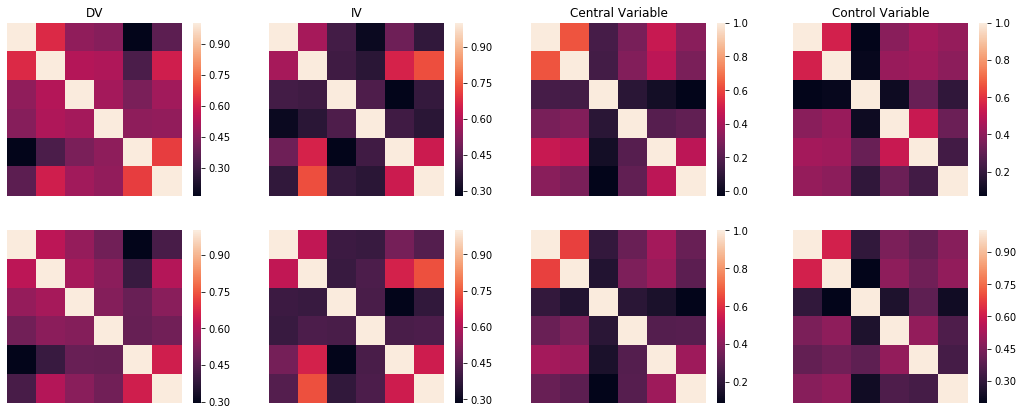

In [76]:
fig, axs = plt.subplots(2,4)
fig.set_size_inches(18, 7)
for k, ax, title in zip(ck,axs[0], titles):
    seaborn.heatmap(k, ax = ax)
    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())
for r, ax in zip(pr,axs[1]):
    seaborn.heatmap(r, ax = ax)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

Now we will compare the student coders.

In [77]:
nondiag = (np.eye(6)-np.ones(6))*-1.0

In [78]:
xdevck = pairwise_matrix(cohens_kappa, anno_dv.annotations)
xdevpr = pairwise_matrix(pearsons_rho, anno_dv.annotations)

xindck = pairwise_matrix(cohens_kappa, anno_iv.annotations)
xindpr = pairwise_matrix(pearsons_rho, anno_iv.annotations)

xcenck = pairwise_matrix(cohens_kappa, anno_cv.annotations)
xcenpr = pairwise_matrix(pearsons_rho, anno_cv.annotations)

xconck = pairwise_matrix(cohens_kappa, anno_ctv.annotations)
xconpr = pairwise_matrix(pearsons_rho, anno_ctv.annotations)

print(np.average(xdevck, weights=nondiag))
print(np.average(xdevpr, weights=nondiag))
print(np.average(xindck, weights=nondiag))
print(np.average(xindpr, weights=nondiag))
print(np.average(xcenck, weights=nondiag))
print(np.average(xcenpr, weights=nondiag))
print(np.average(xconck, weights=nondiag))
print(np.average(xconpr, weights=nondiag))

0.47214258445407015
0.5142407278222342
0.4529627823703711
0.47596526866863437
0.27082376869768193
0.3151404982836273
0.32833477875850064
0.39458527791963466


Now we are going to bring in "gold standard" data. In this case, this is where we asked authors of the articles to code their own article's variables and compare with our student coders.

In [79]:
mergedata = np.loadtxt(fname="../data/dataforgssstudy/gss_mergedataC.txt", dtype=int, delimiter="\t")

In [80]:
anno_merge_dep = AnnotationsContainer.from_array(mergedata[:,0:2])
anno_merge_ind = AnnotationsContainer.from_array(mergedata[:,2:4])
anno_merge_cen = AnnotationsContainer.from_array(mergedata[:,4:6])
anno_merge_con = AnnotationsContainer.from_array(mergedata[:,6:8])
anno_merge_dkn = AnnotationsContainer.from_array(mergedata[:,8:10])

In [81]:
print("""Dependent variable -- kappa & rho""")
print(cohens_kappa(anno_merge_dep.annotations[:,0], anno_merge_dep.annotations[:,1]))
print(pearsons_rho(anno_merge_dep.annotations[:,0], anno_merge_dep.annotations[:,1]))

print("\nIndependent variable")
print(cohens_kappa(anno_merge_ind.annotations[:,0], anno_merge_ind.annotations[:,1]))
print(pearsons_rho(anno_merge_ind.annotations[:,0], anno_merge_ind.annotations[:,1]))

print("\nCentral variable")
print(cohens_kappa(anno_merge_cen.annotations[:,0], anno_merge_cen.annotations[:,1]))
print(pearsons_rho(anno_merge_cen.annotations[:,0], anno_merge_cen.annotations[:,1]))

print("\nControl variable")
print(cohens_kappa(anno_merge_con.annotations[:,0], anno_merge_con.annotations[:,1]))
print(pearsons_rho(anno_merge_con.annotations[:,0], anno_merge_con.annotations[:,1]))

Dependent variable -- kappa & rho
0.3744311057948666
0.38563437203620643

Independent variable
0.5430690164641346
0.5529974941771468

Central variable
-0.064017189548477
-0.08887644319259189

Control variable
0.2815172499181942
0.28239237574620263


Whoah! Student coders and authors viewed articles that were "central" or critical to the published argument as fundamentally different (exhibiting negative agreement and correlation). Why? Likely because that researchers recalled what they had _intended_ as their central variables before analysis, but those that _worked out_ became central in the text.

Now for the assessment of the relative values of authors, then student coders.

In [82]:
print("Dependent")
print(np.average(anno_merge_dep.annotations[:,0]))
print(np.average(anno_merge_dep.annotations[:,1]))

print("\nIndependent")
print(np.average(anno_merge_ind.annotations[:,0]))
print(np.average(anno_merge_ind.annotations[:,1]))

print("\nCentral")
print(np.average(anno_merge_cen.annotations[:,0]))
print(np.average(anno_merge_cen.annotations[:,1]))

print("\nControl")
print(np.average(anno_merge_con.annotations[:,0]))
print(np.average(anno_merge_con.annotations[:,1]))

Dependent
0.4763912310286678
0.35834738617200673

Independent
0.23777403035413153
0.3136593591905565

Central
0.35328836424957843
0.7512647554806071

Control
0.081787521079258
0.09443507588532883


## Now we are going to use models to predict the correct annotations

Recall that Model A is built for 8 coders, but we have 6. We're going to *hack* it by adding two blank columns.

In [83]:
dev.shape

(21461, 6)

In [84]:
negs2 = np.ones((21461, 2), dtype=np.int)*(-1)
devA = np.concatenate((dev, negs2), axis=1)
devA

array([[ 0, -1, -1, ...,  1, -1, -1],
       [ 0, -1, -1, ...,  0, -1, -1],
       [ 0, -1, -1, ...,  0, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [85]:
anno_dvA = AnnotationsContainer.from_array(devA)
model_devA = ModelA.create_initial_state(2)
model_devA.theta

array([0.68019726, 0.68421366, 0.77747406, 0.67440601, 0.9482753 ,
       0.84335305, 0.77476023, 0.85661454])

In [86]:
model_dvB = ModelB.create_initial_state(2, 6)
print(model_dvB.pi)
print(model_dvB.log_likelihood(anno_dv.annotations))

[0.84195513 0.15804487]
-28936.490984227446


In [87]:
model_dvB.map(anno_dv.annotations)
print(model_dvB.pi)
print(model_dvB.log_likelihood(anno_dv.annotations))

[0.69455487 0.30544513]
-25462.473635032595


In [88]:
# compute the posterior distribution over true annotations
posterior_dvB = model_dvB.infer_labels(anno_dv.annotations)
# each row show the probability of each label class for the
# corresponding item
print(posterior)

[[0.01110254 0.28932993 0.36495364 0.33461389]
 [0.99021785 0.00241997 0.00405172 0.00331045]
 [0.00249953 0.05506856 0.93459839 0.00783351]
 ...
 [0.0025289  0.04396839 0.94557718 0.00792553]
 [0.00249387 0.00571338 0.93247846 0.05931429]
 [0.0319025  0.93879857 0.01612446 0.01317447]]


In [89]:
samples_dvB = model_dvB.sample_posterior_over_accuracy(anno_dv.annotations, 200, burn_in_samples=100, thin_samples=3)

In [90]:
# we can then compute a credible interval for the parameters:
ci_dv_mean = samples_dvB[0].mean(axis=0)
print("Mean")
print(ci_dv_mean)

ci_dv_stdev = samples_dvB[0].std(axis=0)
print("\nSTD")
print(ci_dv_stdev)


Mean
[[[0.97917177 0.02082823]
  [0.51519142 0.48480858]]

 [[0.96926813 0.03073187]
  [0.26004731 0.73995269]]

 [[0.98281309 0.01718691]
  [0.3459341  0.6540659 ]]

 [[0.934645   0.065355  ]
  [0.24171258 0.75828742]]

 [[0.6920964  0.3079036 ]
  [0.0464621  0.9535379 ]]

 [[0.86447932 0.13552068]
  [0.06859387 0.93140613]]]

STD
[[[0.00243248 0.00243248]
  [0.01260694 0.01260694]]

 [[0.00310332 0.00310332]
  [0.01404467 0.01404467]]

 [[0.00318697 0.00318697]
  [0.01425148 0.01425148]]

 [[0.00502952 0.00502952]
  [0.01205353 0.01205353]]

 [[0.00711561 0.00711561]
  [0.00569784 0.00569784]]

 [[0.00662926 0.00662926]
  [0.00696079 0.00696079]]]


We will use Model B estimates for other variable assessments.

In [91]:
#test
model_testB = ModelB.create_initial_state(2, 6)
print(model_testB.log_likelihood(anno_test.annotations))
model_testB.map(anno_test.annotations)
print(model_testB.pi)
print(model_testB.log_likelihood(anno_test.annotations))
print(anno_test.annotations.shape)
posterior_testB = model_testB.infer_labels(anno_test.annotations)
print(posterior_testB.shape)
samples_testB = model_testB.sample_posterior_over_accuracy(anno_test.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_test_mean = samples_testB[0].mean(axis=0)
print(ci_test_mean)

-147.16912129239188
[9.20933481e-20 1.00000000e+00]
-48.9756711393957
(48, 6)
(48, 2)
[[[0.79246624 0.20753376]
  [0.12408814 0.87591186]]

 [[0.80617087 0.19382913]
  [0.09283458 0.90716542]]

 [[0.80517332 0.19482668]
  [0.49800184 0.50199816]]

 [[0.80434446 0.19565554]
  [0.07172527 0.92827473]]

 [[0.79755193 0.20244807]
  [0.35924969 0.64075031]]

 [[0.79150488 0.20849512]
  [0.13073382 0.86926618]]]


In [92]:
#indepedent variables
model_ivB = ModelB.create_initial_state(2, 6)
print(model_ivB.log_likelihood(anno_iv.annotations))
model_ivB.map(anno_iv.annotations)
print(model_ivB.pi)
print(model_ivB.log_likelihood(anno_iv.annotations))
print(anno_iv.annotations.shape)
posterior_ivB = model_ivB.infer_labels(anno_iv.annotations)
print(posterior_ivB.shape)
samples_ivB = model_ivB.sample_posterior_over_accuracy(anno_iv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_iv_mean = samples_ivB[0].mean(axis=0)
print(ci_iv_mean)

#central variables
model_cvB = ModelB.create_initial_state(2, 6)
print(model_cvB.log_likelihood(anno_cv.annotations))
model_cvB.map(anno_cv.annotations)
print(model_cvB.pi)
print(model_cvB.log_likelihood(anno_cv.annotations))
print(anno_cv.annotations.shape)
posterior_cvB = model_cvB.infer_labels(anno_cv.annotations)
print(posterior_cvB.shape)
samples_cvB = model_cvB.sample_posterior_over_accuracy(anno_cv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_cv_mean = samples_cvB[0].mean(axis=0)
print(ci_cv_mean)

#control variables
model_ctvB = ModelB.create_initial_state(2, 6)
print(model_ctvB.log_likelihood(anno_ctv.annotations))
model_ctvB.map(anno_ctv.annotations)
print(model_ctvB.pi)
print(model_ctvB.log_likelihood(anno_ctv.annotations))
print(anno_ctv.annotations.shape)
posterior_ctvB = model_ctvB.infer_labels(anno_ctv.annotations)
print(posterior_ctvB.shape)
samples_ctvB = model_ctvB.sample_posterior_over_accuracy(anno_iv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_ctv_mean = samples_ctvB[0].mean(axis=0)
print(ci_ctv_mean)

-34024.90132872954
[0.61093546 0.38906454]
-28620.66523246587
(21461, 6)
(21461, 2)
[[[0.97126391 0.02873609]
  [0.34787516 0.65212484]]

 [[0.9380335  0.0619665 ]
  [0.05358892 0.94641108]]

 [[0.65781752 0.34218248]
  [0.21068706 0.78931294]]

 [[0.53712172 0.46287828]
  [0.0308278  0.9691722 ]]

 [[0.8760677  0.1239323 ]
  [0.09892236 0.90107764]]

 [[0.89159407 0.10840593]
  [0.08982731 0.91017269]]]
-35137.87582288547
[0.23988844 0.76011156]
-25034.918555765576
(21461, 6)
(21461, 2)
[[[0.89145809 0.10854191]
  [0.07019298 0.92980702]]

 [[0.78335442 0.21664558]
  [0.05724791 0.94275209]]

 [[0.99247921 0.00752079]
  [0.84140131 0.15859869]]

 [[0.95090461 0.04909539]
  [0.45574934 0.54425066]]

 [[0.67552427 0.32447573]
  [0.05709583 0.94290417]]

 [[0.58977081 0.41022919]
  [0.09579441 0.90420559]]]
-24122.511527270766
[0.83068326 0.16931674]
-19415.702035242168
(21461, 6)
(21461, 2)
[[[0.97054747 0.02945253]
  [0.34555443 0.65444557]]

 [[0.93655071 0.06344929]
  [0.05124528 0.9

Now we will package up the predicted data into a format we can use for other, subsequent analysis:

In [93]:
print(posterior_dvB.shape)
print(posterior_ivB.shape)
print(posterior_cvB.shape)
print(posterior_ctvB.shape)

(21461, 2)
(21461, 2)
(21461, 2)
(21461, 2)


In [94]:
predicted_annotations = np.concatenate((posterior_dvB, posterior_ivB, posterior_cvB, posterior_ctvB), axis=1) # posterior_dvBt, posterior_ivBt, posterior_cvBt, posterior_ctvBt), axis=1)

In [95]:
predicted_annotations.shape

(21461, 8)

These annotations allowed us to uncover the degree to which social scientists alter their models to achieve a better fit...undocumented data mining. The answer was that social scientists did mine their data, but that it likely improved their analysis because change in the social world was the result of greater distortion than undocumented data mining.

## Another example analysis looks at a different data set of Hotel Reviews by a variety of patrons.

In [96]:
df_hotels = pandas.read_csv('../data/hot_Reviews.csv', index_col=0)
df_hotels[:5]

,Karen,Scott,Jessica,write a review,A verified traveler,Kevin,William,R,S,Christopher,...,Thomas,Susan,A Traveler,M,Not Provided,B,Laura,xxxxxxxxxxxxxx,Michael,Joseph
1785 Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900 House,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bed & Breakfast In Cambridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Swallow's Nest Motel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abbeville Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here a rank of 0 is a missing value and to simplify things more we will convert from a 1-10 scale to a 1-5 scale, with 0 as missing

In [97]:
df_hotels = df_hotels.apply(lambda x: x // 2) #integer divide by 2 rounds all values

And we can visualize all the reviews as a heatmap with the missing values greyed out

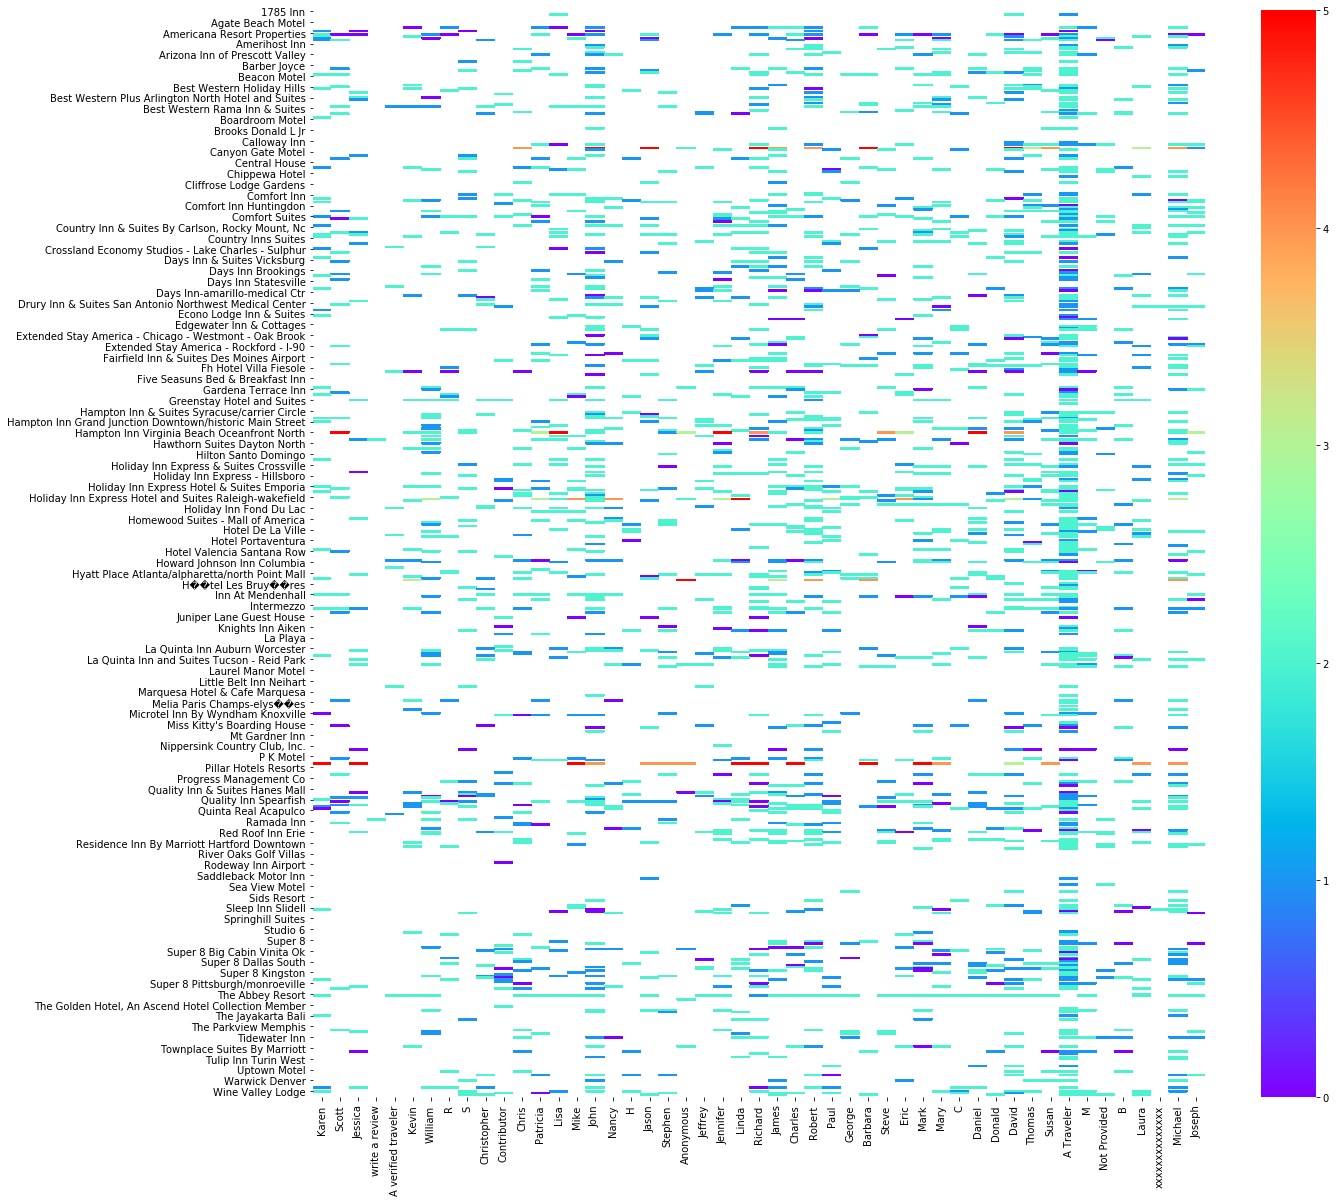

In [98]:
fig, ax = plt.subplots(figsize = (20,20))
seaborn.heatmap(df_hotels, cmap='rainbow', ax = ax)
plt.show()

To give the dataframe to pyanno we need to convert to np array and change the nans to intergers, lets use -1

In [99]:
hot_mat = np.array(df_hotels.fillna(-1).as_matrix())
anno_hot = AnnotationsContainer.from_array(hot_mat, missing_values=[-1])

In [100]:
anno_hot.annotations

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [101]:
anno_hot.labels

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

In [102]:
anno_hot.missing_values

[-1]

Look at coder agreement

In [103]:
pyanno.measures.agreement.labels_frequency(anno_hot.annotations, 6)#6 possible catagories

array([0.07806534, 0.26262198, 0.63555367, 0.00636402, 0.0093339 ,
       0.00806109])

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


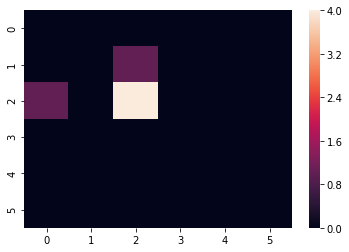

In [104]:
c = pyanno.measures.agreement.confusion_matrix(anno_hot.annotations[:,0], anno_hot.annotations[:,1], 6) #6 possible catagories
print(c)
ac = seaborn.heatmap(c)
plt.show()

Most agreement is on 2 i.e. an average hotel and there's little agreement as rating go higher, likely due to scarcity in the sample

In [105]:
scotts_pi(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.3787878787878787

In [106]:
krippendorffs_alpha(anno_hot.annotations[::])

0.398760907615921

In [107]:
cohens_kappa(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.40328336902212697

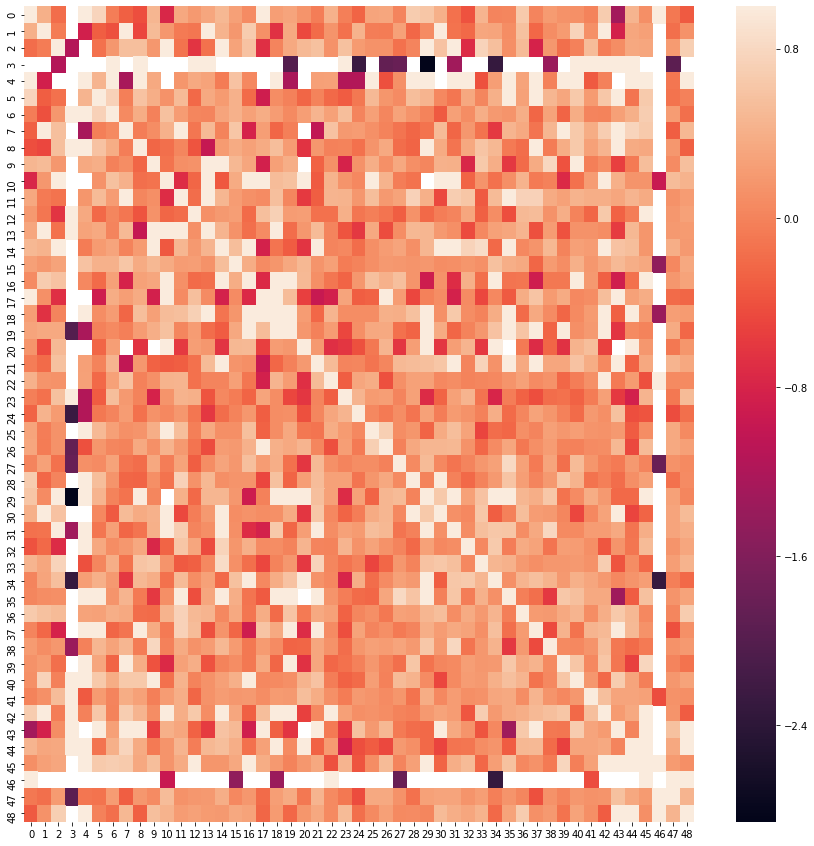

In [108]:
m = pairwise_matrix(cohens_kappa, anno_hot.annotations)
fig, ax = plt.subplots(figsize = (15, 15))
seaborn.heatmap(m, ax =ax)

In [125]:
model_hot = ModelBt.create_initial_state(6, 49)
model_hot.mle(anno_hot.annotations)
print(model_hot.theta)
print(model_hot.log_likelihood(anno_hot.annotations))

[0.63763872 0.67135941 0.81279026 0.86260525 0.84741422 0.6986629
 0.71201558 0.80180318 0.75311376 0.68322005 0.73678504 0.8193189
 0.66196516 0.74564301 0.81425832 0.69672535 0.76178015 0.81724407
 0.63284458 0.78005355 0.72031493 0.81359895 0.71108868 0.69322932
 0.71425365 0.7482219  0.68698449 0.71929616 0.56879654 0.75375272
 0.73479755 0.71607205 0.64743129 0.71844588 0.73255415 0.80354961
 0.72166849 0.82135323 0.70637207 0.71600876 0.83537874 0.74418333
 0.66870964 0.75353832 0.69932459 0.74149097 0.99960741 0.76514486
 0.75061395]
-2707.968230504408


In [110]:
def makeQuestionComparison(model, anno_target, num_questions = 20):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    # compute the posterior distribution over true annotations
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

(<Figure size 1080x720 with 4 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1429b8390>,
  <matplotlib.axes._subplots.AxesSubplot at 0x15f9e7240>))

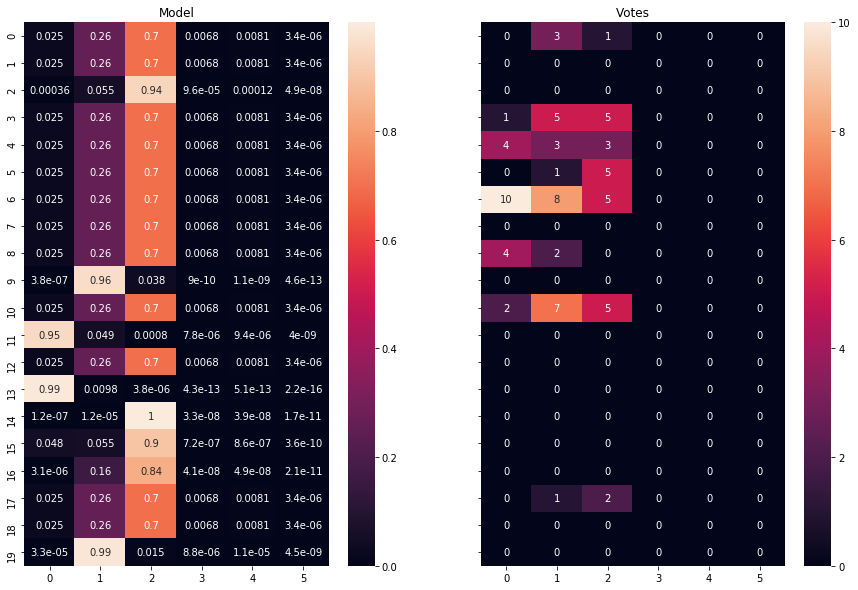

In [111]:
makeQuestionComparison(model_hot, anno_hot)

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?

### Using Model B

In [174]:
pyanno.measures.agreement.labels_frequency(anno1.annotations,5)

array([0.21666667, 0.43333333, 0.28333333, 0.03333333, 0.03333333])

In [185]:
# create an instance of model B, with 5 label classes and 25 annotators
model = ModelB.create_initial_state(5, 25)

In [186]:
# model.pi contains the prior probability of each label class, random
print(model.pi)

[0.19780513 0.19111198 0.14471358 0.4020516  0.06431771]


In [187]:
# log likelihood of the model before parameters optimization
print(model.log_likelihood(anno1.annotations))

-87.88406961621415


In [188]:
# estimate the parameters from the observed data using MAP
model.map(anno1.annotations)

In [189]:
print(model.theta)

[[[7.89473684e-001 1.57894737e-001 5.26315796e-002 0.00000000e+000
   0.00000000e+000]
  [1.28005427e-001 6.60513359e-001 1.68812738e-001 4.26684756e-002
   0.00000000e+000]
  [4.24385287e-002 1.49378293e-001 6.38429064e-001 1.27315586e-001
   4.24385287e-002]
  [0.00000000e+000 4.54545455e-002 1.36363636e-001 6.81818182e-001
   1.36363636e-001]
  [0.00000000e+000 0.00000000e+000 5.26315789e-002 1.57894737e-001
   7.89473684e-001]]

 [[7.89473717e-001 1.57894712e-001 5.26315705e-002 0.00000000e+000
   0.00000000e+000]
  [1.66964668e-001 6.66064108e-001 1.25228418e-001 4.17428059e-002
   0.00000000e+000]
  [4.34023540e-002 1.32079896e-001 6.50935066e-001 1.30187013e-001
   4.33956710e-002]
  [0.00000000e+000 4.54545455e-002 1.36363636e-001 6.81818182e-001
   1.36363636e-001]
  [0.00000000e+000 0.00000000e+000 5.26315789e-002 1.57894737e-001
   7.89473684e-001]]

 [[7.89473684e-001 1.57894737e-001 5.26315789e-002 8.68805145e-211
   0.00000000e+000]
  [1.66897769e-001 6.32766828e-001 1.26

In [190]:
print(model.pi)

[2.81337344e-07 7.68135163e-01 2.31864556e-01 1.19698237e-80
 0.00000000e+00]


In [191]:
# log likelihood after optimization improved
print(model.log_likelihood(anno1.annotations))

-70.9115346535899


(<Figure size 1080x720 with 4 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x163025d68>,
  <matplotlib.axes._subplots.AxesSubplot at 0x162a568d0>))

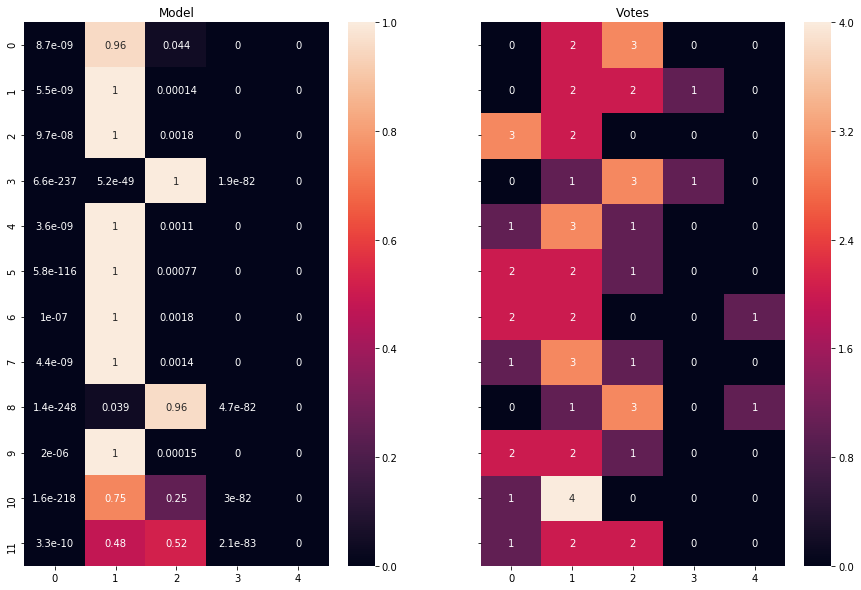

In [192]:
makeQuestionComparison(model, anno1)

Overall, there are a range of high and low quality raters. The model and taking the majority vote produces pretty similar results. The patterns are not too different, although there are some where the model chooses differently from the majority vote, for example breaking ties in question 2 and 12 and choosing a different option from the majority in question 1 and 3.

In [217]:
samples = model.sample_posterior_over_accuracy(anno1.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples[0].mean(axis=0)
y_ci = samples[0].std(axis=0)

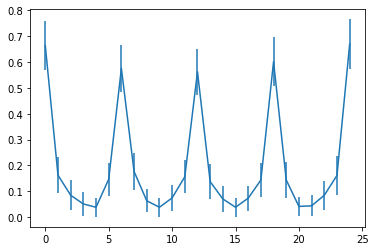

In [219]:
plt.figure()
plt.errorbar(range(25),y[0].flatten(), yerr = y_ci[0].flatten())
plt.show()

As we see from the graph above, the raters varied greatly in their quality of rating with only 5 raters who are of much higher quality than the rest out of the 25.

### Using Model Bt

In [199]:
# create a new instance of model Bt, with 4 label classes and 8 annotators.
model_Bt = ModelBt.create_initial_state(5, 25)
print(model.log_likelihood(anno1.annotations))

-70.9115346535899


In [200]:
model_Bt.map(anno1.annotations)
print(model_Bt.theta)
print(model_Bt.log_likelihood(anno1.annotations))
# Log likelihood did not improve with this model

[0.75461529 0.97179858 0.68763258 0.95309435 0.62631052 0.78947669
 0.58561505 0.24947082 0.98320402 0.99999999 0.6522804  0.99995936
 0.95075121 0.55915138 0.74534981 0.49939155 0.72046668 0.87444075
 0.99999895 0.75699948 0.89046082 0.77738271 0.79794515 0.58161503
 0.88217809]
-88.7791007827787


(<Figure size 1080x720 with 4 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x13cb54b70>,
  <matplotlib.axes._subplots.AxesSubplot at 0x160b77358>))

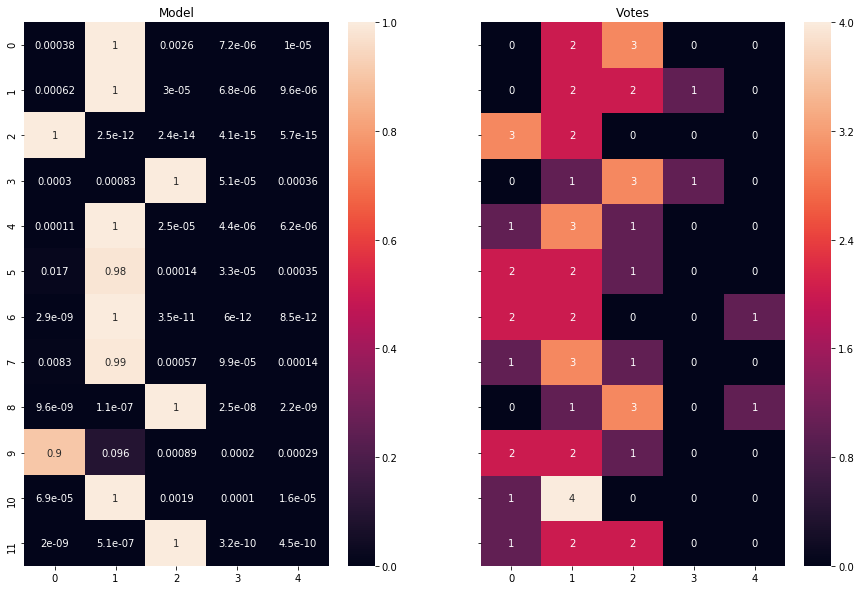

In [201]:
makeQuestionComparison(model_Bt, anno1)

Model Bt followed the majority vote almost always, while breaking ties. The only exception was in question 1 where it gave a different label than the majority vote. This is quite notably different from Model B above that showed greater discretion between the coders of different quality. I am inclined to use model B because the log likelihood worsened with this model.